#### imports

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

from lifelines import KaplanMeierFitter, WeibullAFTFitter, LogNormalAFTFitter, LogLogisticAFTFitter

In [99]:
SEED = 42

np.random.seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

#### Data Loading


In [100]:
df = pd.read_csv("data/telco.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        1000 non-null   int64 
 1   region    1000 non-null   object
 2   tenure    1000 non-null   int64 
 3   age       1000 non-null   int64 
 4   marital   1000 non-null   object
 5   address   1000 non-null   int64 
 6   income    1000 non-null   int64 
 7   ed        1000 non-null   object
 8   retire    1000 non-null   object
 9   gender    1000 non-null   object
 10  voice     1000 non-null   object
 11  internet  1000 non-null   object
 12  forward   1000 non-null   object
 13  custcat   1000 non-null   object
 14  churn     1000 non-null   object
dtypes: int64(5), object(10)
memory usage: 117.3+ KB


In [101]:
df["churn"] = df["churn"].map({"Yes": 1, "No": 0}).astype(int)
df = df.rename(columns={"tenure": "T"})

duration_col = "T"
event_col = "churn"

df[[duration_col, event_col]].head()


,T,churn
0,13,1
1,11,1
2,68,0
3,33,1
4,23,0


In [102]:
categorical_cols = [
    "region", "marital", "ed", "retire",
    "gender", "voice", "internet", "forward", "custcat"
]

for col in categorical_cols:
    df[col] = df[col].astype("category")

df_dum = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
df_dum = df_dum.drop(columns=["ID"], errors="ignore")
df_dum.head()


,T,age,address,income,churn,region_Zone 2,region_Zone 3,marital_Unmarried,ed_Did not complete high school,ed_High school degree,ed_Post-undergraduate degree,ed_Some college,retire_Yes,gender_Male,voice_Yes,internet_Yes,forward_Yes,custcat_E-service,custcat_Plus service,custcat_Total service
0,13,44,9,64,1,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False
1,11,33,7,136,1,False,True,False,False,False,True,False,False,True,True,False,True,False,False,True
2,68,52,24,116,0,False,True,False,True,False,False,False,False,False,False,False,False,False,True,False
3,33,33,12,33,1,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False
4,23,30,9,30,0,True,False,False,True,False,False,False,False,True,False,False,True,False,True,False


In [103]:
print("Missing values total:", df_dum.isna().sum().sum())

Missing values total: 0


#### Exploratory Data Analysis (EDA)


In [104]:
df[['T', 'age', 'address', 'income']].describe().T

,count,mean,std,min,25%,50%,75%,max
T,1000.0,35.526,21.359812,1.0,17.0,34.0,54.0,72.0
age,1000.0,41.684,12.558816,18.0,32.0,40.0,51.0,77.0
address,1000.0,11.551,10.086681,0.0,3.0,9.0,18.0,55.0
income,1000.0,77.535,107.044165,9.0,29.0,47.0,83.0,1668.0


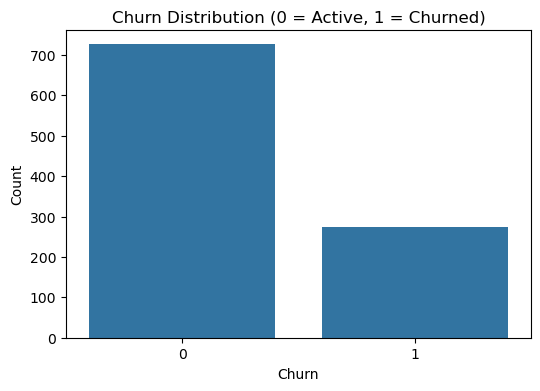

In [105]:
plt.figure(figsize=(6,4))
sns.countplot(x='churn', data=df)
plt.title("Churn Distribution (0 = Active, 1 = Churned)")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.show()

The churn variable is moderately imbalanced:  
around 70–75% of subscribers remain active (`churn = 0`), while approximately 25–30% have churned (`churn = 1`).  

Thus we can conclude that both churned and non-churned customers are represented.



/var/folders/zb/hn9yb4sj16sdk1rnbgl9p2jr0000gn/T/ipykernel_79157/4203148580.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='churn', y='T', data=df, palette='cool')


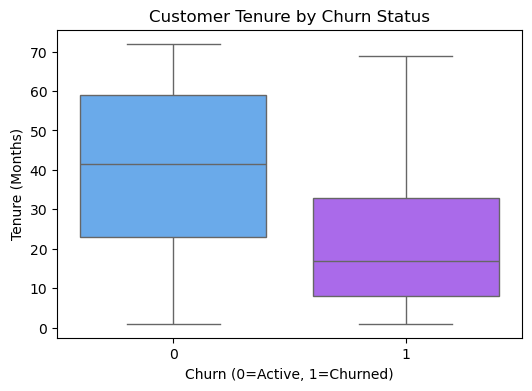

In [106]:
plt.figure(figsize=(6,4))
sns.boxplot(x='churn', y='T', data=df, palette='cool')
plt.title("Customer Tenure by Churn Status")
plt.xlabel("Churn (0=Active, 1=Churned)")
plt.ylabel("Tenure (Months)")
plt.show()

Customers who have not churned (`churn = 0`) generally show longer tenures,  
with a median around 40 months, whereas churned customers (`churn = 1`) have  
a much shorter median tenure, roughly 15–20 months.

This clear difference indicates that customers who stay longer are significantly less likely to churn.  

/var/folders/zb/hn9yb4sj16sdk1rnbgl9p2jr0000gn/T/ipykernel_79157/2193523433.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='churn', y='income', data=df, ci=None, palette='pastel')
/var/folders/zb/hn9yb4sj16sdk1rnbgl9p2jr0000gn/T/ipykernel_79157/2193523433.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='churn', y='income', data=df, ci=None, palette='pastel')


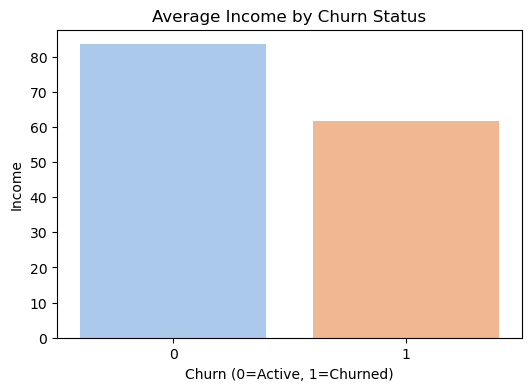

In [107]:
plt.figure(figsize=(6,4))
sns.barplot(x='churn', y='income', data=df, ci=None, palette='pastel')
plt.title("Average Income by Churn Status")
plt.xlabel("Churn (0=Active, 1=Churned)")
plt.ylabel("Income")
plt.show()

Active customers (`churn = 0`) have a noticeably **higher average income**  
(around 80–85K) compared to churned customers (`churn = 1`), whose average income is closer to **60–65K**.  

This suggests that **lower-income subscribers are more likely to churn**,  
possibly due to greater price sensitivity or lower perceived value in the service.  
Income therefore appears to be an important factor influencing churn.

#### Kaplan–Meier Survival Curve

In [108]:
kmf = KaplanMeierFitter()
kmf.fit(durations=df["T"], event_observed=df["churn"], label="Overall Survival")

<lifelines.KaplanMeierFitter:"Overall Survival", fitted with 1000 total observations, 726 right-censored observations>

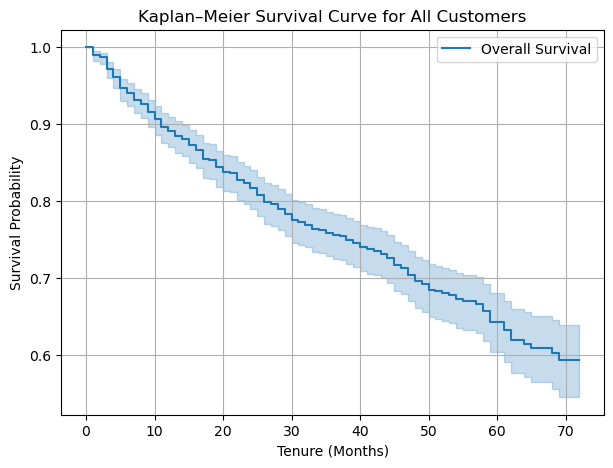

In [109]:
plt.figure(figsize=(7,5))
kmf.plot_survival_function()
plt.title("Kaplan–Meier Survival Curve for All Customers")
plt.xlabel("Tenure (Months)")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()

The Kaplan–Meier survival curve shows a steady decline in customer survival probability over time. At the beginning (0–10 months), survival drops sharply from 1.0 to around 0.9, indicating that new customers are more likely to churn early. After about 30 months, the curve declines more gradually, suggesting that long-term subscribers have a higher likelihood of remaining loyal.

By the end of the observation period (~70 months), the survival probability stabilizes near 0.6,  
meaning that roughly 60% of customers remain active.  

#### AFT Models

In [110]:
feature_cols = [c for c in df_dum.columns if c not in ["T", "churn"]]

aft_models = {
    "WeibullAFT": WeibullAFTFitter(),
    "LogNormalAFT": LogNormalAFTFitter(),
    "LogLogisticAFT": LogLogisticAFTFitter()
}

for name, model in aft_models.items():
    print(f"Fitting {name} ...")
    model.fit(df_dum[["T", "churn"] + feature_cols],
              duration_col="T",
              event_col="churn", fit_options={"seed": SEED})
    aft_models[name] = model

Fitting WeibullAFT ...
Fitting LogNormalAFT ...
Fitting LogLogisticAFT ...


In [111]:
comparison = []

for name, m in aft_models.items():
    comparison.append({
        "model": name,
        "log_likelihood": m.log_likelihood_,
        "AIC": m.AIC_,
        "BIC": m.BIC_
    })

comparison_df = pd.DataFrame(comparison).sort_values("AIC")
comparison_df

,model,log_likelihood,AIC,BIC
1,LogNormalAFT,-1457.012005,2954.024010,2927.839521
2,LogLogisticAFT,-1458.104281,2956.208561,2930.024072
0,WeibullAFT,-1462.171624,2964.343248,2938.158759


The Log-Normal AFT model has the highest log-likelihood and the lowest AIC and BIC values.  
Therefore, it provides the best fit for the churn data and will be selected as the final model for interpretation and CLV estimation.

This suggests that customer survival times follow a distribution that is symmetric on the log scale (as assumed by the Log-Normal model), meaning that both early and late churners exist, but most customers fall around an average survival duration.

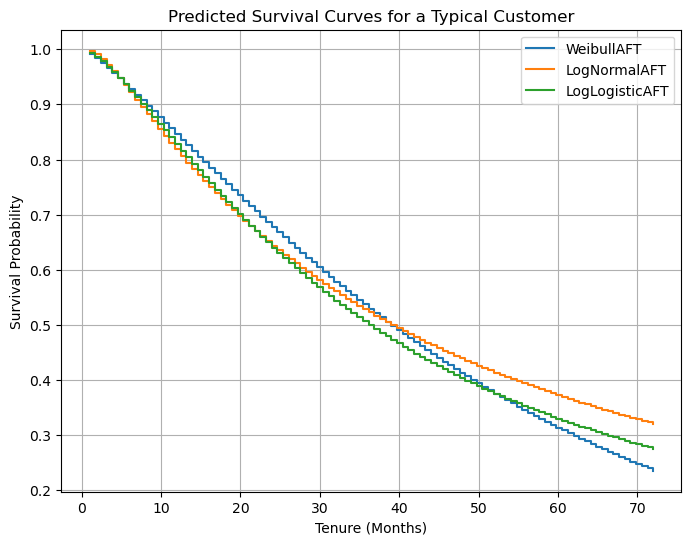

In [112]:
typ_dict = {}
for col in feature_cols:
    if df_dum[col].nunique() > 2:    
        typ_dict[col] = df_dum[col].median()
    else:                       
        typ_dict[col] = df_dum[col].mode()[0]

typ_df = pd.DataFrame([typ_dict])
time_grid = np.linspace(1, df_dum["T"].max(), 100)

plt.figure(figsize=(8,6))

for name, model in aft_models.items():
    sf = model.predict_survival_function(typ_df, times=time_grid)
    plt.step(sf.index, sf.iloc[:, 0], where="post", label=name)

plt.title("Predicted Survival Curves for a Typical Customer")
plt.xlabel("Tenure (Months)")
plt.ylabel("Survival Probability")
plt.legend()
plt.grid(True)
plt.show()

The Log-Normal AFT curve (orange) shows a slightly slower decay at longer tenures (after ~40 months).
The Weibull model (blue) declines more sharply, suggesting it may underestimate long-term retention,  
while the Log-Logistic model (green) falls slightly below the Log-Normal curve at high tenures, indicating overestimation of late-stage churn.

These visual differences confirm that the Log-Normal AFT model best captures both early and late churn behavior —  
supporting the statistical comparison above.

In [113]:
mu_part = aft_models["LogNormalAFT"].summary.loc["mu_"]
significant_features = mu_part[mu_part["p"] < 0.05]
significant_features


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
address,0.042538,1.043456,0.008904,0.025088,0.059989,1.025405,1.061825,0.0,4.777676,1.773326e-06,19.105111
age,0.032670,1.033209,0.007254,0.018452,0.046887,1.018624,1.048004,0.0,4.503760,6.676160e-06,17.192550
custcat_E-service,1.066401,2.904907,0.170532,0.732165,1.400637,2.079579,4.057784,0.0,6.253394,4.016273e-10,31.213423
custcat_Plus service,0.924929,2.521689,0.215751,0.502065,1.347793,1.652129,3.848923,0.0,4.287021,1.810853e-05,15.752971
custcat_Total service,1.198617,3.315528,0.250452,0.707741,1.689493,2.029401,5.416735,0.0,4.785820,1.702906e-06,19.163569
internet_Yes,-0.771490,0.462324,0.143483,-1.052710,-0.490269,0.348991,0.612462,0.0,-5.376880,7.578744e-08,23.653466
marital_Unmarried,-0.455134,0.634363,0.115430,-0.681372,-0.228896,0.505922,0.795411,0.0,-3.942958,8.048267e-05,13.600962
voice_Yes,-0.433787,0.648050,0.168953,-0.764929,-0.102646,0.465367,0.902447,0.0,-2.567503,1.024338e-02,6.609164
Intercept,2.362263,10.614950,0.292629,1.788721,2.935805,5.981799,18.836666,0.0,8.072559,6.883999e-16,50.367603


In [114]:
sig_cols = [c for c in significant_features.index if c != "Intercept"]
print("Significant features used:", sig_cols)

Significant features used: ['address', 'age', 'custcat_E-service', 'custcat_Plus service', 'custcat_Total service', 'internet_Yes', 'marital_Unmarried', 'voice_Yes']


In [115]:
final_model = LogNormalAFTFitter()
final_model.fit(
    df_dum[["T", "churn"] + sig_cols],
    duration_col="T",
    event_col="churn"
)


<lifelines.LogNormalAFTFitter: fitted with 1000 total observations, 726 right-censored observations>

In [116]:
final_model.summary

coef  exp(coef)  se(coef)  coef lower 95%  \
param  covariate                                                              
mu_    address                0.042824   1.043754  0.008847        0.025483   
       age                    0.036826   1.037512  0.006400        0.024283   
       custcat_E-service      1.025825   2.789395  0.169047        0.694499   
       custcat_Plus service   0.822553   2.276303  0.169425        0.490485   
       custcat_Total service  1.013269   2.754590  0.209579        0.602501   
       internet_Yes          -0.840528   0.431483  0.138259       -1.111511   
       marital_Unmarried     -0.447317   0.639341  0.114472       -0.671679   
       voice_Yes             -0.463493   0.629082  0.166771       -0.790359   
       Intercept              2.534887  12.615010  0.242611        2.059379   
sigma_ Intercept              0.283034   1.327150  0.046020        0.192836   

                              coef upper 95%  exp(coef) lower 95%  \
param  covariate                                                    
mu_    address                      0.060164             1.025811   
       age                          0.049369             1.024580   
       custcat_E-service            1.357150             2.002706   
       custcat_Plus service         1.154620             1.633109   
       custcat_Total service        1.424036             1.826682   
       internet_Yes                -0.569545             0.329061   
       marital_Unmarried           -0.222956             0.510850   
       voice_Yes                   -0.136628             0.453682   
       Intercept                    3.010396             7.841100   
sigma_ Intercept                    0.373231             1.212684   

                              exp(coef) upper 95%  cmp to          z  \
param  covariate                                                       
mu_    address                           1.062011     0.0   4.840293   
       age                               1.050608     0.0   5.754395   
       custcat_E-service                 3.885105     0.0   6.068295   
       custcat_Plus service              3.172818     0.0   4.854960   
       custcat_Total service             4.153852     0.0   4.834781   
       internet_Yes                      0.565783     0.0  -6.079365   
       marital_Unmarried                 0.800150     0.0  -3.907654   
       voice_Yes                         0.872294     0.0  -2.779221   
       Intercept                        20.295430     0.0  10.448373   
sigma_ Intercept                         1.452420     0.0   6.150258   

                                         p   -log2(p)  
param  covariate                                       
mu_    address                1.296478e-06  19.556971  
       age                    8.695261e-09  26.777123  
       custcat_E-service      1.292752e-09  29.526907  
       custcat_Plus service   1.204113e-06  19.663598  
       custcat_Total service  1.332924e-06  19.516974  
       internet_Yes           1.206593e-09  29.626414  
       marital_Unmarried      9.319665e-05  13.389362  
       voice_Yes              5.448947e-03   7.519807  
       Intercept              1.490611e-25  82.472298  
sigma_ Intercept              7.735690e-10  30.267751

#### CLV

In [117]:
t_horizon = 24
times = np.arange(1, t_horizon + 1)


In [118]:
sf_all = final_model.predict_survival_function(df_dum[sig_cols], times=times)
surv_matrix = sf_all.values.T 
surv_matrix.shape

(1000, 24)

In [119]:
MM = 1300    
r = 0.10   

discount_factors = 1 / (1 + r/12) ** np.arange(t_horizon)
discounted_surv = surv_matrix * discount_factors
clv = MM * discounted_surv.sum(axis=1)
df["CLV"] = clv


In [120]:

df["CLV"].describe()

count     1000.000000
mean     25356.548299
std       3179.556795
min       9177.301919
25%      23672.037741
50%      26450.449681
75%      27854.917692
max      28405.866558
Name: CLV, dtype: float64

In [121]:
print(df.groupby("custcat")["CLV"].agg(["mean", "count"]).sort_values("mean", ascending=False))


                       mean  count
custcat                           
Plus service   27032.773335    281
E-service      26444.111154    217
Total service  24680.470193    236
Basic service  23298.405660    266


/var/folders/zb/hn9yb4sj16sdk1rnbgl9p2jr0000gn/T/ipykernel_79157/609452078.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby("custcat")["CLV"].agg(["mean", "count"]).sort_values("mean", ascending=False))


In [122]:
print(df.groupby("internet")["CLV"].agg(["mean", "count"]))

                  mean  count
internet                     
No        26437.114613    632
Yes       23500.793106    368


/var/folders/zb/hn9yb4sj16sdk1rnbgl9p2jr0000gn/T/ipykernel_79157/2924477960.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby("internet")["CLV"].agg(["mean", "count"]))


In [123]:
df["income_band"] = pd.cut(df["income"],
                           bins=[0, 40, 80, df["income"].max()],
                           labels=["Low", "Medium", "High"])

print(df.groupby("income_band")["CLV"].agg(["mean", "count"]).sort_values("mean", ascending=False))

                     mean  count
income_band                     
High         26792.880628    264
Medium       25543.100377    321
Low          24298.536365    415


/var/folders/zb/hn9yb4sj16sdk1rnbgl9p2jr0000gn/T/ipykernel_79157/269736206.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby("income_band")["CLV"].agg(["mean", "count"]).sort_values("mean", ascending=False))


In [124]:
df_dum["CLV"] = df["CLV"]

In [125]:
def one_year_churn_prob(row):
    x_row = row[sig_cols].to_frame().T
    surv = final_model.predict_survival_function(x_row, times=np.array([0, 12]))
    S0, S12 = surv.values.flatten()
    return 1 - (S12 / S0)

df_dum["p_churn_1y"] = df_dum.apply(one_year_churn_prob, axis=1)

In [126]:
at_risk = df_dum[df_dum["p_churn_1y"] > 0.5]

In [127]:
len(at_risk)

14

In [128]:
at_risk["CLV"].sum()

186469.23931718664

In [129]:
annual_retention_budget = (at_risk["CLV"] * 0.10).sum()
annual_retention_budget

18646.923931718662

In [130]:
df_dum["p_churn_1y"].describe()

count    1000.000000
mean        0.110565
std         0.123586
min         0.000016
25%         0.015962
50%         0.064525
75%         0.171002
max         0.756390
Name: p_churn_1y, dtype: float64

#### Report

I used an AFT model to understand what affects customer churn. A positive coefficient in an AFT model means a customer is expected to stay longer, while a negative coefficient means they churn sooner. 

According to my final model, customers in E-service, Plus service, and Total service categories tend to stay the longest, and older customers or those who have lived longer at the same address also show longer survival, which in some sense feels quite logical. 
On the other hand, customers with internet or voice services and unmarried subscribers have negative coefficients, which means they churn earlier and represent higher-risk groups.

Using the AFT survival curves, I calculated CLV for each customer and compared results across segments. 
In my case, I consider a segment valuable when it combines high CLV with low churn risk, and in this dataset, the multi-service groups (E-service, Plus service, and Total service) clearly stand out as the most valuable. 

To estimate the annual retention budget, I first calculated each customer’s one-year churn probability. I defined at-risk customers as those with a churn probability above 50%, representing a group with a very high likelihood of leaving. Based on this threshold, only 14 customers were classified as high-risk. Their combined CLV was approximately 186,469, and allocating 10% of this value results in a recommended retention budget of about 18,650. This is the amount neeeded to target only the customers who matter financially and are most likely to churn. 

As a strategy, the company should focus on these high-risk customers—especially those with internet and voice services—and offer for example loyalty rewards, or small price adjustments. 